In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pvlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 69.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import pvlib

In [4]:

# ================================================
# LEITURA E TRATAMENTO DA CHUVA - INMET
# ================================================

# Certifique-se de que este caminho está correto para o seu ambiente
diretorio_pluv = '/content/drive/MyDrive/Trabalho final paula/INMET_CO_DF_A001_BRASILIA_01-01-2023_A_31-12-2023.CSV'

# 1) Leitura do CSV sem conversão de datas inicial no read_csv
df_pluv = pd.read_csv(
    diretorio_pluv,
    sep=';',
    encoding='latin1',
    decimal=',',
    skiprows = 8
)

# Combine 'Data' and 'Hora UTC' into a single string column
df_pluv['datetime_str'] = df_pluv['Data'] + ' ' + df_pluv['Hora UTC']

# **CORREÇÃO DO VALUERROR:**
# O formato de data e hora é ajustado para '%Y/%m/%d %H%M %Z'
# para corresponder ao formato 'YYYY/MM/DD HHMM UTC' (ex: 2023/01/01 0000 UTC)
df_pluv['datetime'] = pd.to_datetime(
    df_pluv['datetime_str'],
    format="%Y/%m/%d %H%M %Z",
    errors='coerce' # Usa 'coerce' para lidar com qualquer dado malformado, se houver
)

# Drop the original 'Data', 'Hora UTC', and temporary 'datetime_str' columns
df_pluv.drop(columns=['Data', 'Hora UTC', 'datetime_str'], inplace=True)

# 2) Renomear coluna
df_pluv.rename(columns={
    'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': 'precip_mm'
}, inplace=True)

# 3) Converter valores inválidos
# O pandas já tentará converter para float, substituindo valores inválidos por NaN
df_pluv['precip_mm'] = pd.to_numeric(df_pluv['precip_mm'], errors='coerce')

# 4) Colocar datetime como índice
# Remove linhas com datetime inválido antes de definir o índice
df_pluv.dropna(subset=['datetime'], inplace=True)
df_pluv.set_index('datetime', inplace=True)

# 5) Reamostrar para chuva diária
# A função sum() é robusta e ignora os valores NaN
chuva_diaria = df_pluv['precip_mm'].resample('D').sum().to_frame()
chuva_diaria.rename(columns={'precip_mm': 'Chuva_Diaria_mm'}, inplace=True)

# ================================================
# FILTRAR PERÍODO 19-07 a 31-12 PARA UM ANO ESPECÍFICO
# ================================================

ANO = 2023  # <-- Ano desejado

# Filtrar apenas o ano específico
chuva_ano = chuva_diaria[chuva_diaria.index.year == ANO]

# Filtrar intervalo 19/07 a 31/12 (filtragem eficiente usando strings de data)
chuva_filtrada = chuva_ano.loc[f"{ANO}-07-19": f"{ANO}-12-31"]

# Transformar índice para apenas data (YYYY-MM-DD)
# Converte o índice de datetime para apenas a parte da data
chuva_filtrada.index = chuva_filtrada.index.date

# Mostrar resultado
print("Chuva Diária Filtrada (19/07/2023 a 31/12/2023):")
print("-" * 50)
print(chuva_filtrada.head())
print("-" * 50)
print(f"Total de dias no período filtrado: {len(chuva_filtrada)}")

Chuva Diária Filtrada (19/07/2023 a 31/12/2023):
--------------------------------------------------
            Chuva_Diaria_mm
2023-07-19              0.0
2023-07-20              0.0
2023-07-21              0.0
2023-07-22              0.0
2023-07-23              0.0
--------------------------------------------------
Total de dias no período filtrado: 166


Tamanho do DataFrame PM10 Combinado: 166
Tamanho do DataFrame PM2.5 Combinado: 166


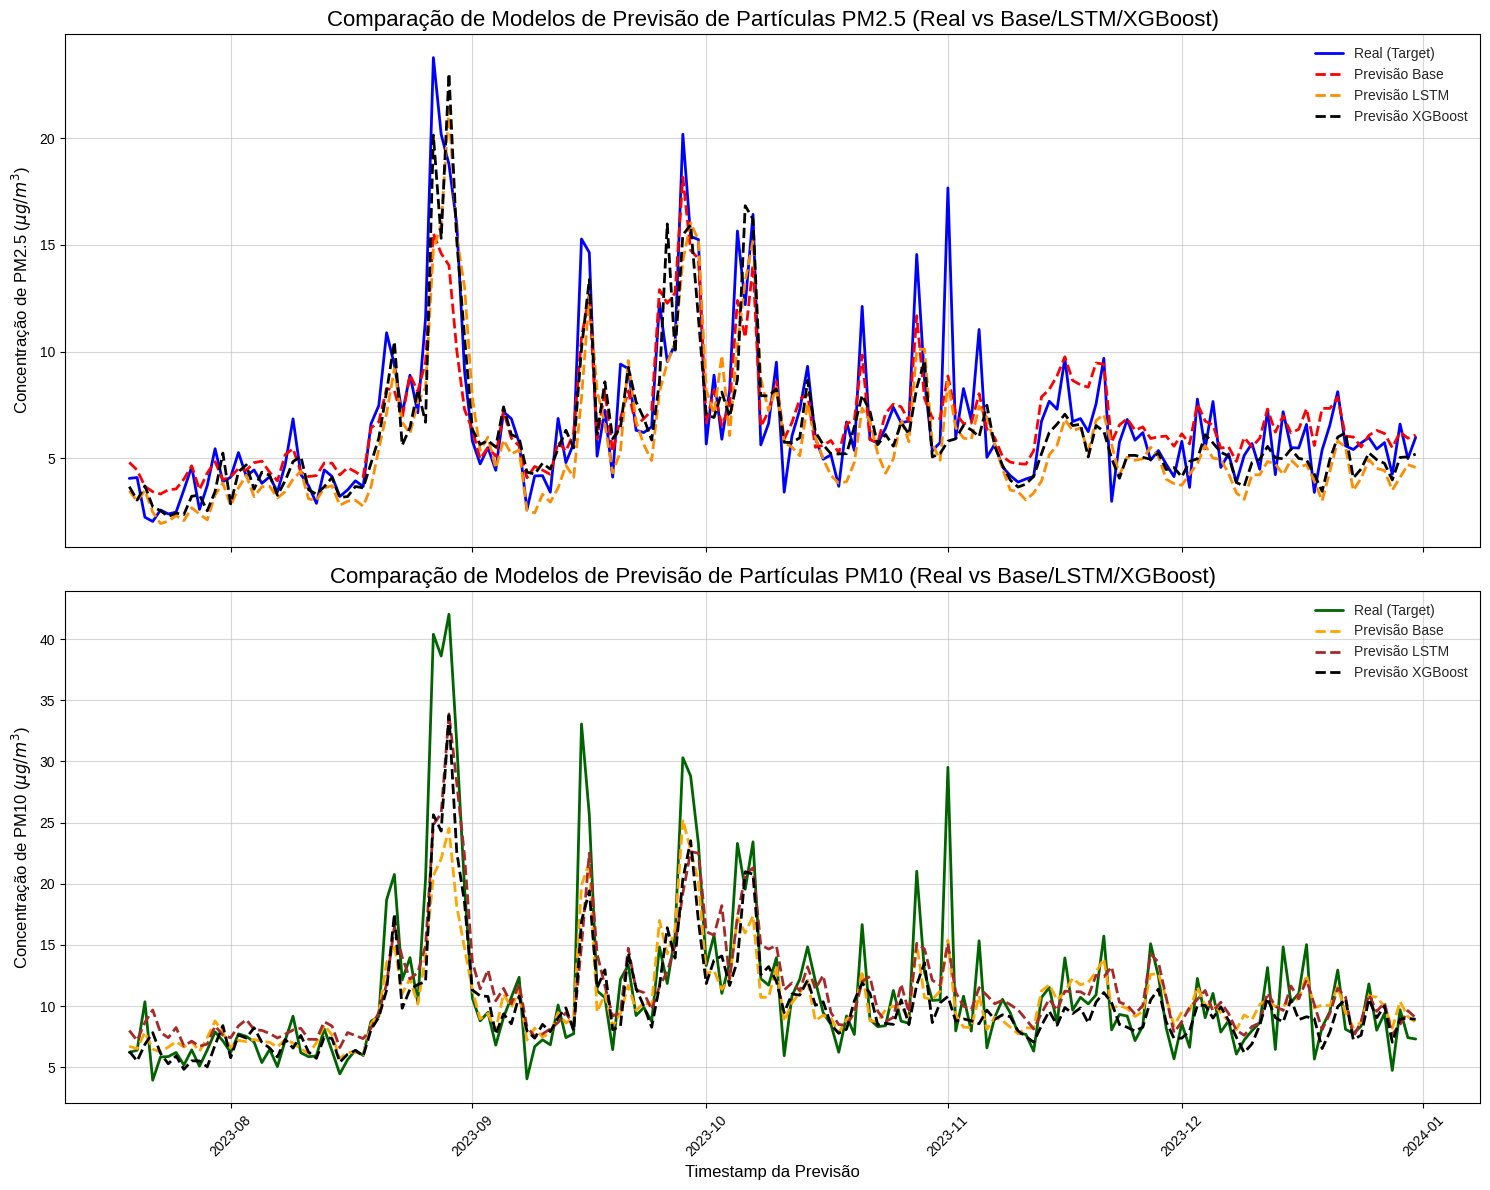

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# ====================================================================
# 1. LEITURA, CONVERSÃO E PREPARAÇÃO DOS DADOS
# ====================================================================

# Caminhos dos arquivos
arquivo1 = '/content/drive/MyDrive/Trabalho final paula/pm10_media_brasilia.csv'
arquivo2 = '/content/drive/MyDrive/Trabalho final paula/pm25_media_brasilia.csv'
arquivo3 = '/content/drive/MyDrive/Trabalho final paula/pred_LSTM_PM10_Brasília.csv'
arquivo4 = '/content/drive/MyDrive/Trabalho final paula/pred_LSTM_PM25_Brasília.csv'
arquivo5 = '/content/drive/MyDrive/Trabalho final paula/pred_XGB_PM10_Brasília.csv'
arquivo6 = '/content/drive/MyDrive/Trabalho final paula/pred_XGB_PM25_Brasília.csv'

# Colunas de referência
coluna_tempo = 'Data'
coluna_tempo_pred = 'Unnamed: 0'

# --- Funções de Tratamento com Normalização ---

def normalizar_tempo(dt_series):
    """Garante que a série de datetime seja naive e normalizada (sem horas/minutos, se houver)."""
    if dt_series.dt.tz is not None:
        dt_series = dt_series.dt.tz_localize(None) # Remove timezone
    return dt_series.dt.normalize() # Normaliza para meia-noite (00:00:00)

def tratar_base(df, poluente):
    """
    Trata os arquivos base (PM10 e PM25) e define o índice.
    Ajustado para os nomes: <poluente>_Target_Real_Daily_Avg e <poluente>_Prediction_Daily_Avg
    """

    # Define os nomes corretos das colunas no dataset base
    col_target = f'{poluente}_Target_Real_Daily_Avg'
    col_pred_base = f'{poluente}_Prediction_Daily_Avg'

    # 1. Conversão de tempo e normalização
    df[coluna_tempo] = pd.to_datetime(df[coluna_tempo])
    df[coluna_tempo] = normalizar_tempo(df[coluna_tempo])

    # 2. Conversão de valor (Garantindo limpeza de vírgulas e tipos corretos)
    # CORREÇÃO CRÍTICA: Tratar o TARGET REAL e a PREDICTION BASE separadamente
    df[col_target] = df[col_target].astype(str).str.replace(',', '.', regex=True).astype(float)
    df[col_pred_base] = df[col_pred_base].astype(str).str.replace(',', '.', regex=True).astype(float)

    # 3. Renomear e definir índice
    df.rename(columns={
        col_pred_base: 'Pred_Base',
        col_target: f'{poluente}_Target_Real' # Renomeia o target para o nome curto usado no plot
    }, inplace=True)
    df.set_index(coluna_tempo, inplace=True)

    return df

def tratar_previsao(df, modelo, poluente):
    """Trata os arquivos de previsão (LSTM/XGB) e define o índice."""

    # 1. Conversão de tempo e normalização
    df[coluna_tempo_pred] = pd.to_datetime(df[coluna_tempo_pred])
    df[coluna_tempo_pred] = normalizar_tempo(df[coluna_tempo_pred])

    # 2. Conversão de valor (coluna no índice 1)
    df[f'Pred_{modelo}'] = df.iloc[:, 1].astype(str).str.replace(',', '.', regex=True).astype(float)

    # 3. Definir índice e limpeza
    df.set_index(coluna_tempo_pred, inplace=True)

    return df[['Pred_' + modelo]]

# Leitura e Tratamento dos Dados
df_pm10 = tratar_base(pd.read_csv(arquivo1), 'pm10')
df_pm25 = tratar_base(pd.read_csv(arquivo2), 'pm25') # O nome do poluente deve ser 'pm25' (minúsculo) para a função
# df_pm25 foi corrigido para usar 'pm25' (minúsculo) para se alinhar com o nome das colunas 'pm25_Target_Real_Daily_Avg'

df_pm10_lstm = tratar_previsao(pd.read_csv(arquivo3), 'LSTM', 'pm10')
df_pm25_lstm = tratar_previsao(pd.read_csv(arquivo4), 'LSTM', 'pm25')
df_pm10_xgb = tratar_previsao(pd.read_csv(arquivo5), 'XGB', 'pm10')
df_pm25_xgb = tratar_previsao(pd.read_csv(arquivo6), 'XGB', 'pm25')

# ====================================================================
# 2. COMBINAÇÃO DOS DADOS (USANDO CONCAT PELO ÍNDICE NORMALIZADO)
# ====================================================================

# O nome da coluna target foi ajustado na função tratar_base.

# COMBINAÇÃO PM10
df_pm10_combined = pd.concat([
    df_pm10[['pm10_Target_Real', 'Pred_Base']],
    df_pm10_lstm,
    df_pm10_xgb
], axis=1, join='inner')

# COMBINAÇÃO PM2.5
df_pm25_combined = pd.concat([
    df_pm25[['pm25_Target_Real', 'Pred_Base']],
    df_pm25_lstm,
    df_pm25_xgb
], axis=1, join='inner')

# Imprimir o tamanho do DataFrame combinado para verificar se está vazio
print(f"Tamanho do DataFrame PM10 Combinado: {len(df_pm10_combined)}")
print(f"Tamanho do DataFrame PM2.5 Combinado: {len(df_pm25_combined)}")

# Se os tamanhos forem 0, o problema é nos dados. Se forem > 0, o gráfico irá plotar.
if len(df_pm10_combined) == 0 or len(df_pm25_combined) == 0:
    print("\n⚠️ ALERTA: DataFrames combinados estão vazios. Confirme se as colunas de tempo têm valores correspondentes nos arquivos.")
    # Exibe as primeiras datas de cada arquivo para depuração manual
    print("\nPrimeiras datas nos arquivos:")
    print(f"PM10 Base: {df_pm10.index[:5].tolist()}")
    print(f"PM10 LSTM: {df_pm10_lstm.index[:5].tolist()}")
    print(f"PM10 XGB: {df_pm10_xgb.index[:5].tolist()}")

# ====================================================================
# 3. CONFIGURAÇÃO DOS SUBPLOTS COM MÚLTIPLOS MODELOS
# ====================================================================

if len(df_pm10_combined) > 0 and len(df_pm25_combined) > 0:
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 12), sharex=True)
    plt.style.use('seaborn-v0_8-whitegrid')

    # --- Subplot 1: PM2.5 ---
    ax1 = axes[0]
    ax1.plot(df_pm25_combined.index, df_pm25_combined['pm25_Target_Real'],
             label='Real (Target)', color='blue', linewidth=2)
    ax1.plot(df_pm25_combined.index, df_pm25_combined['Pred_Base'],
             label='Previsão Base', color='red', linestyle='--', linewidth=2)
    ax1.plot(df_pm25_combined.index, df_pm25_combined['Pred_LSTM'],
             label='Previsão LSTM', color='darkorange', linestyle='--', linewidth=2)
    ax1.plot(df_pm25_combined.index, df_pm25_combined['Pred_XGB'],
             label='Previsão XGBoost', color='black', linestyle='--', linewidth=2)

    ax1.set_title('Comparação de Modelos de Previsão de Partículas PM2.5 (Real vs Base/LSTM/XGBoost)', fontsize=16)
    ax1.set_ylabel('Concentração de PM2.5 ($\\mu g/m^3$)', fontsize=12)
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.5)

    # --- Subplot 2: PM10 ---
    ax2 = axes[1]
    ax2.plot(df_pm10_combined.index, df_pm10_combined['pm10_Target_Real'],
             label='Real (Target)', color='darkgreen', linewidth=2)
    ax2.plot(df_pm10_combined.index, df_pm10_combined['Pred_Base'],
             label='Previsão Base', color='orange', linestyle='--', linewidth=2)
    ax2.plot(df_pm10_combined.index, df_pm10_combined['Pred_LSTM'],
             label='Previsão LSTM', color='brown', linestyle='--', linewidth=2)
    ax2.plot(df_pm10_combined.index, df_pm10_combined['Pred_XGB'],
             label='Previsão XGBoost', color='black', linestyle='--', linewidth=2)

    ax2.set_title('Comparação de Modelos de Previsão de Partículas PM10 (Real vs Base/LSTM/XGBoost)', fontsize=16)
    ax2.set_xlabel('Timestamp da Previsão', fontsize=12)
    ax2.set_ylabel('Concentração de PM10 ($\\mu g/m^3$)', fontsize=12)
    ax2.legend(loc='upper right', fontsize=10)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.5)

    plt.tight_layout()
    plt.show()
else:
    print("Gráficos não plotados devido à incompatibilidade total de datas.")

In [6]:
# Coluna de tempo (definida para o contexto, mas não usada para merge, pois é o índice)
coluna_tempo_atual = 'Data'

df_pmgeral = pd.merge(df_pm10, df_pm25, left_index=True, right_index=True, how='inner')

# 2. Re-amostragem (mantida por solicitação)
df_pmgeral = df_pmgeral.resample("D").mean()

# 3. Exibir o resultado
print("✅ df_pmgeral (Dados de PM10 e PM25 Alinhados):")
print("-" * 50)
print(df_pmgeral.head())

✅ df_pmgeral (Dados de PM10 e PM25 Alinhados):
--------------------------------------------------
            pm10_Target_Real  Pred_Base_x  pm25_Target_Real  Pred_Base_y
Data                                                                    
2023-07-19             6.222     6.713571             4.055     4.801738
2023-07-20             6.393     6.520796             4.097     4.448132
2023-07-21            10.353     7.858189             2.234     3.680164
2023-07-22             3.945     6.484754             2.038     3.431020
2023-07-23             5.840     6.260559             2.572     3.322573



--- Resultados de Sujidade ---
Precipitação Máxima: 25.20 mm
PM2.5 Máximo Real (ug/m³): 23.7810

Maior perda Real (Target): SR = 0.9827
Maior perda Base (Sintético): SR = 0.9842
Maior perda LSTM: SR = 0.9807
Maior perda XGBoost: SR = 0.9841


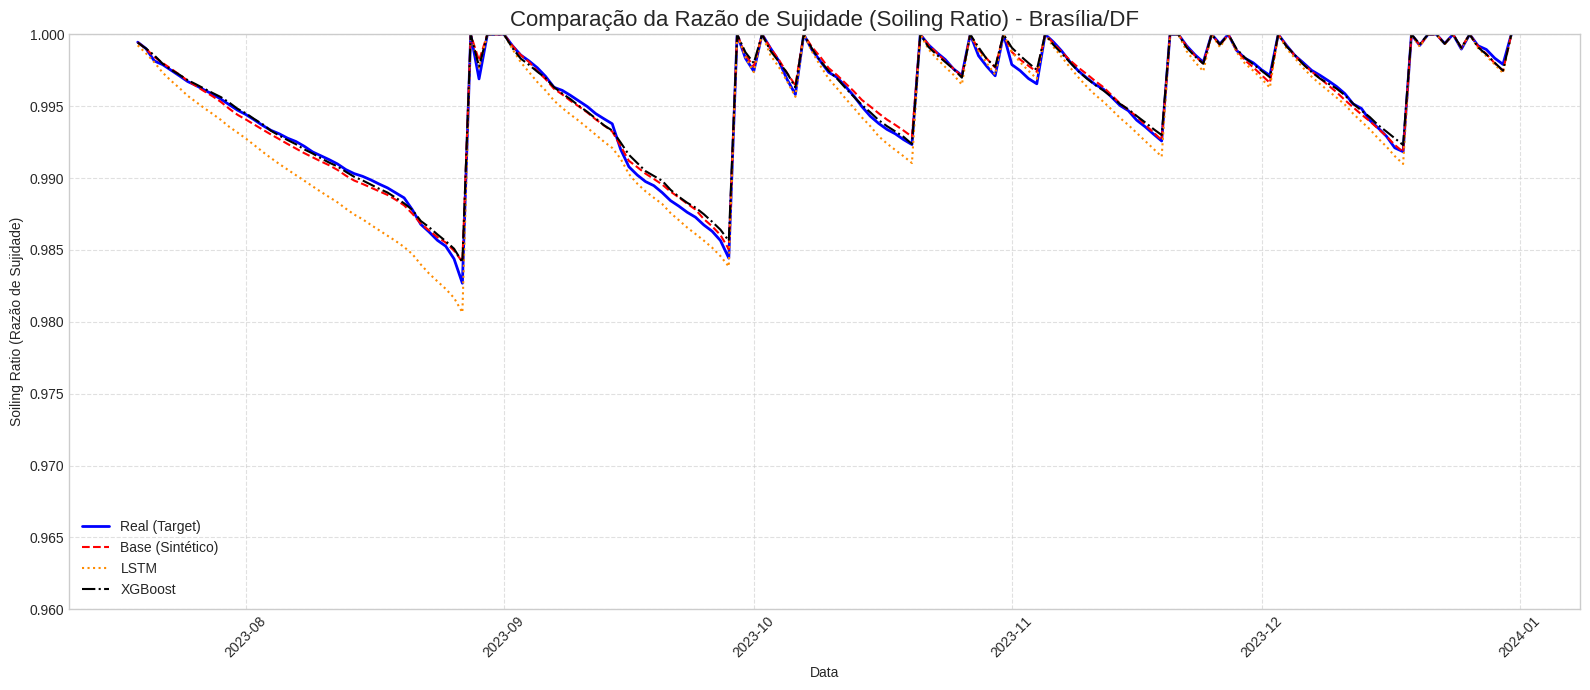

In [7]:
import pvlib
from pvlib import soiling
import pandas as pd
import matplotlib.pyplot as plt

# ================================================================
# 1. PARÂMETROS FIXOS
# ================================================================
CLEANING_THRESHOLD = 6               # chuva (mm) que limpa o módulo
SUPERFICIE_INCLINACAO = 16           # tilt do módulo (graus)
PERIODO_ACUMULACAO = pd.Timedelta('1D')  # período de acumulação de chuva

# ================================================================
# 2. PREPARAR E ALINHAR OS DADOS
# ================================================================

# --- Índice de chuva deve ser DateTime ---
chuva = chuva_filtrada['Chuva_Diaria_mm'].copy()
chuva.index = pd.to_datetime(chuva.index, errors='coerce')
chuva = chuva[~chuva.index.isna()]   # remove datas inválidas se houver

# Obter período comum
start_date = df_pmgeral.index.min()
end_date = df_pmgeral.index.max()

# PM sintético
pm2_5_sint = df_pmgeral['Pred_Base_y'].loc[start_date:end_date]
pm10_sint = df_pmgeral['Pred_Base_x'].loc[start_date:end_date]

# PM real
pm2_5_real = df_pmgeral['pm25_Target_Real'].loc[start_date:end_date]
pm10_real = df_pmgeral['pm10_Target_Real'].loc[start_date:end_date]

# --- Converter unidades µg/m³ → g/m³ ---
FATOR_CONVERSAO = 1_000_000

#REAL
pm2_5_real1 = pm2_5_real / FATOR_CONVERSAO
pm10_real1 = pm10_real / FATOR_CONVERSAO

#TRANSFORMER
pm2_5_sint1 = pm2_5_sint / FATOR_CONVERSAO
pm10_sint1 = pm10_sint / FATOR_CONVERSAO

# PM LSTM
pm2_5_lstm = df_pm25_lstm['Pred_LSTM'] / FATOR_CONVERSAO
pm10_lstm = df_pm10_lstm['Pred_LSTM'] / FATOR_CONVERSAO

# PM XGBoost
pm2_5_xgb = df_pm25_xgb['Pred_XGB'] / FATOR_CONVERSAO
pm10_xgb = df_pm10_xgb['Pred_XGB'] / FATOR_CONVERSAO



# ================================================================
# 3. MODELO HSU — CÁLCULO DO SOILING RATIO PARA TODOS OS MODELOS
# ================================================================

# SR 1: Baseado no PM Real (Target)
soiling_ratio_real = soiling.hsu(
rainfall=chuva, cleaning_threshold=CLEANING_THRESHOLD, surface_tilt=SUPERFICIE_INCLINACAO,
pm2_5=pm2_5_real1, pm10=pm10_real1, rain_accum_period=PERIODO_ACUMULACAO, depo_veloc={'2_5': 0.005, '10': 0.01}
)

# SR 2: Baseado no PM Sintético (Base Prediction)
soiling_ratio_base = soiling.hsu(
rainfall=chuva, cleaning_threshold=CLEANING_THRESHOLD, surface_tilt=SUPERFICIE_INCLINACAO,
pm2_5=pm2_5_sint1, pm10=pm10_sint1, rain_accum_period=PERIODO_ACUMULACAO, depo_veloc={'2_5': 0.005, '10': 0.01}
)

# SR 3: Baseado no PM LSTM
soiling_ratio_lstm = soiling.hsu(
rainfall=chuva, cleaning_threshold=CLEANING_THRESHOLD, surface_tilt=SUPERFICIE_INCLINACAO,
pm2_5=pm2_5_lstm, pm10=pm10_lstm, rain_accum_period=PERIODO_ACUMULACAO, depo_veloc={'2_5': 0.005, '10': 0.01}
)

# SR 4: Baseado no PM XGBoost
soiling_ratio_xgb = soiling.hsu(
rainfall=chuva, cleaning_threshold=CLEANING_THRESHOLD, surface_tilt=SUPERFICIE_INCLINACAO,
pm2_5=pm2_5_xgb, pm10=pm10_xgb, rain_accum_period=PERIODO_ACUMULACAO, depo_veloc={'2_5': 0.005, '10': 0.01}
)


# ================================================================
# 4. EXIBIÇÃO DOS RESULTADOS
# ================================================================

print("\n--- Resultados de Sujidade ---")
print(f"Precipitação Máxima: {chuva.max():.2f} mm")
print(f"PM2.5 Máximo Real (ug/m³): {df_pmgeral['pm25_Target_Real'].max():.4f}")

# Pior momento de sujidade
pior_razao_real = soiling_ratio_real.min()
pior_razao_lstm = soiling_ratio_lstm.min()
pior_razao_xgb = soiling_ratio_xgb.min()
pior_razao_base = soiling_ratio_base.min()


print(f"\nMaior perda Real (Target): SR = {pior_razao_real:.4f}")
print(f"Maior perda Base (Sintético): SR = {pior_razao_base:.4f}")
print(f"Maior perda LSTM: SR = {pior_razao_lstm:.4f}")
print(f"Maior perda XGBoost: SR = {pior_razao_xgb:.4f}")

# ================================================================
# 5. GRÁFICO DE COMPARAÇÃO DE SR
# ================================================================

plt.figure(figsize=(16, 7))
plt.plot(soiling_ratio_real.index, soiling_ratio_real.values, label='Real (Target)', linewidth=2, color='blue')
plt.plot(soiling_ratio_base.index, soiling_ratio_base.values, label='Base (Sintético)', linestyle='--', linewidth=1.5, color='red')
plt.plot(soiling_ratio_lstm.index, soiling_ratio_lstm.values, label='LSTM', linestyle=':', linewidth=1.5, color='darkorange')
plt.plot(soiling_ratio_xgb.index, soiling_ratio_xgb.values, label='XGBoost', linestyle='-.', linewidth=1.5, color='black')

plt.title('Comparação da Razão de Sujidade (Soiling Ratio) - Brasília/DF', fontsize=16)
plt.xlabel('Data')
plt.ylabel('Soiling Ratio (Razão de Sujidade)')
plt.ylim(0.96, 1.0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Cálculo das Métricas de Erro do Soiling Ratio (SR)

## 📊 Tabela de Métricas de Erro (Soiling Ratio)
Modelo  Transformer      LSTM   XGBoost
MAE        0.000271  0.000920  0.000250
MBE       -0.000044  0.000874 -0.000106
RMSE       0.000372  0.001269  0.000376
nMAE       0.000273  0.000925  0.000251
nMBE      -0.000044  0.000878 -0.000106
nRMSE      0.000374  0.001275  0.000378


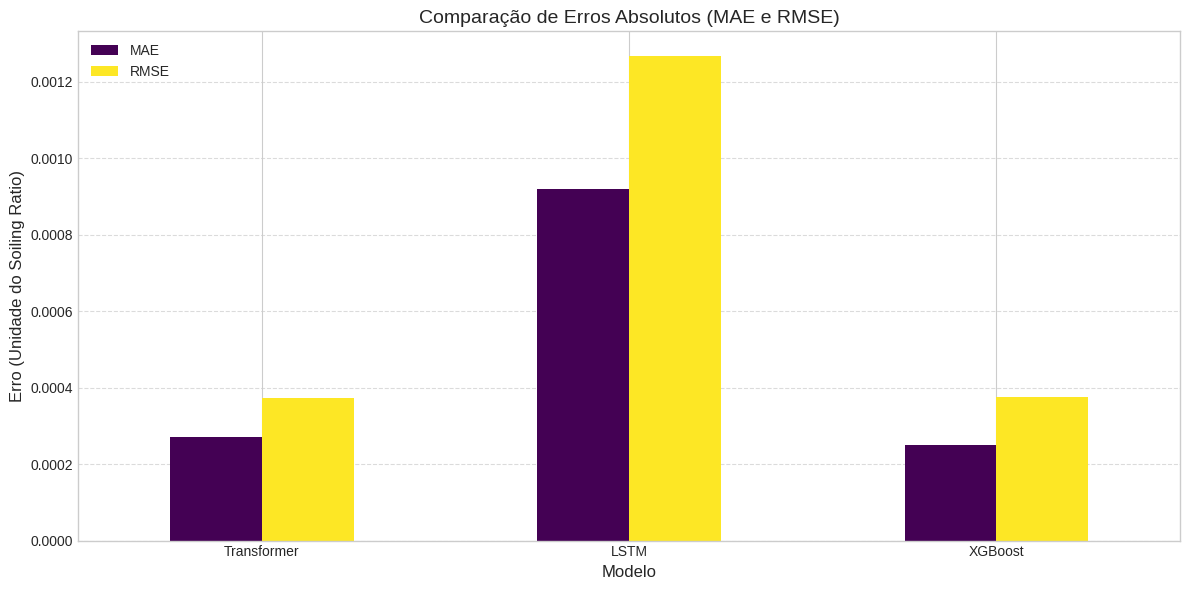

In [8]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ================================================================
# 6. FUNÇÃO PARA CÁLCULO E NORMALIZAÇÃO DAS MÉTRICAS
# ================================================================

def calculate_metrics(y_true, y_pred, model_name):
    """
    Calcula MAE, MBE, RMSE e suas versões normalizadas (nMAE, nMBE, nRMSE).
    A normalização é feita pela média de y_true (Soiling Ratio Real).
    """

    # --- CORREÇÃO DO ERRO 'tuple' object has no attribute 'dropna' ---
    # Alinha as duas séries em um DataFrame e remove NaNs para ter apenas datas em comum.
    df_aligned = pd.concat([y_true.rename('Y_True'), y_pred.rename('Y_Pred')], axis=1, join='inner').dropna()

    if len(df_aligned) == 0:
        print(f"Aviso: Não há datas em comum entre SR Real e {model_name}.")
        return {'Modelo': model_name, 'MAE': np.nan, 'MBE': np.nan, 'RMSE': np.nan,
                'nMAE': np.nan, 'nMBE': np.nan, 'nRMSE': np.nan}

    y_true_final = df_aligned['Y_True']
    y_pred_final = df_aligned['Y_Pred']

    # --- Cálculo das Métricas ---

    errors = y_true_final - y_pred_final
    mean_true = y_true_final.mean()

    # Métricas de Erro Absoluto
    mae = mean_absolute_error(y_true_final, y_pred_final)
    rmse = np.sqrt(mean_squared_error(y_true_final, y_pred_final))
    mbe = errors.mean() # Mean Bias Error

    # Métricas Normalizadas (Divididas pela média do valor real)
    nmae = mae / mean_true
    nrmse = rmse / mean_true
    nmbe = mbe / mean_true

    return {
        'Modelo': model_name,
        'MAE': mae,
        'MBE': mbe,
        'RMSE': rmse,
        'nMAE': nmae,
        'nMBE': nmbe,
        'nRMSE': nrmse,
    }

# ================================================================
# 7. CÁLCULO DAS MÉTRICAS E GERAÇÃO DA TABELA
# ================================================================

print("\n" + "="*50)
print("Cálculo das Métricas de Erro do Soiling Ratio (SR)")
print("="*50)

# Calcular métricas para cada modelo contra o SR Real
metrics_base = calculate_metrics(soiling_ratio_real, soiling_ratio_base, 'Transformer')
metrics_lstm = calculate_metrics(soiling_ratio_real, soiling_ratio_lstm, 'LSTM')
metrics_xgb = calculate_metrics(soiling_ratio_real, soiling_ratio_xgb, 'XGBoost')

# Montar o DataFrame de resultados
results_df = pd.DataFrame([metrics_base, metrics_lstm, metrics_xgb])
results_df = results_df.set_index('Modelo')

# Formatação para impressão e tabela
results_df_styled = results_df.T.round(6)

print("\n## 📊 Tabela de Métricas de Erro (Soiling Ratio)")
print(results_df_styled)


# ================================================================
# 8. GRÁFICOS DE COMPARAÇÃO DAS MÉTRICAS
# ================================================================

# DataFrame de plotagem (apenas as métricas necessárias)
plot_df = results_df[['MAE', 'RMSE', 'nMAE', 'nRMSE']]

### Gráfico 1: MAE e RMSE (Valores Absolutos)
plt.figure(figsize=(12, 6))
plot_df[['MAE', 'RMSE']].plot(kind='bar', rot=0, ax=plt.gca(), cmap='viridis')
plt.title('Comparação de Erros Absolutos (MAE e RMSE)', fontsize=14)
plt.ylabel('Erro (Unidade do Soiling Ratio)', fontsize=12)
plt.xlabel('Modelo', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
